# **1. Create a connection to the database**

In [ ]:
# Install newer version of pip (Colab is currently shipping with an older version)
!pip install -U pip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 25.5 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 22.0.4
    Uninstalling pip-22.0.4:
      Successfully uninstalled pip-22.0.4


In [ ]:
# Install official Neo4j driver
!pip install neo4j

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.0/171.0 kB 6.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for neo4j: filename=neo4j-5.5.0-py3-none-any.whl size=237190 sha256=910e14c787c32d45e06b7bea0568048673cafdaec367263e64d1dda43e26f78c
  Stored in directory: /root/.cache/pip/wheels/97/c9/83/0fb16d527cc493642bc4f69b6c8463b5816ca041b62c0c2d5f
Successfully built neo4j


In [ ]:
# Import the required libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from neo4j import GraphDatabase
from datetime import datetime

In [ ]:
# Connection details for the database
# If using Neo4j Sandbox enter the bolt URL

url = "bolt://3.83.95.52:7687" 
user = "neo4j"
pwd = "rushes-levers-bud"

In [ ]:
class Neo4jConnection:

  def __init__(self, url, user, pwd):

    self.__url = url
    self.__user = user
    self.__pwd = pwd
    self.__driver = None

    try:
      self.__driver = GraphDatabase.driver(self.__url, auth = (self.__user, self.__pwd))
    except Exception as e:
      print("Failed to create the driver", e)

  def close(self):

    if self.__driver is not None:
      self.__driver.close()

  def query(self, query, parameters = None, db = None):

    assert self.__driver is not None, "Driver not initialised!"
    session = None
    response = None

    try:
      session = self.__driver.session(database = db) if db is not None else self.__driver.session()
      response = list(session.run(query, parameters))
    except Exception as e:
      print("Query failed", e)
    finally:
      if session is not None:
        session.close()
    return response 


In [ ]:
# Connect to the database
# If no error message is returned the connection was successful 
conn = Neo4jConnection(url = url, 
                       user = user,              
                       pwd = pwd)

# **2. Create the nodes and relationships**

In [ ]:
# Links to datasets
# Just memo items as parameterisation did not work 

# Full dataset: 
"https://raw.githubusercontent.com/MissMaya/CASA0004_DISSERTATION/main/full_cleaned_data/full_individuals_cleaned.csv"
"https://raw.githubusercontent.com/MissMaya/CASA0004_DISSERTATION/main/full_cleaned_data/full_relationships_cleaned.csv"
"https://raw.githubusercontent.com/MissMaya/CASA0004_DISSERTATION/main/full_cleaned_data/full_addresses_cleaned.csv"
"https://raw.githubusercontent.com/MissMaya/CASA0004_DISSERTATION/main/full_cleaned_data/full_locations_cleaned.csv"
"https://raw.githubusercontent.com/MissMaya/CASA0004_DISSERTATION/main/full_cleaned_data/full_trades_guilds_cleaned.csv"
"https://raw.githubusercontent.com/MissMaya/CASA0004_DISSERTATION/main/full_cleaned_data/full_addresses_cleaned.csv"
"https://raw.githubusercontent.com/MissMaya/CASA0004_DISSERTATION/main/full_cleaned_data/time_intervals.csv"

# Subset used for testing queries:
"https://raw.githubusercontent.com/MissMaya/CASA0004_DISSERTATION/main/subset_cleaned_data/subset_individuals_cleaned.csv"
"https://github.com/MissMaya/CASA0004_DISSERTATION/blob/main/subset_cleaned_data/subset_relationships_cleaned.csv"
"https://raw.githubusercontent.com/MissMaya/CASA0004_DISSERTATION/main/subset_cleaned_data/subset_addresses_cleaned.csv"
"https://raw.githubusercontent.com/MissMaya/CASA0004_DISSERTATION/main/subset_cleaned_data/subset_locations_cleaned.csv"
"https://raw.githubusercontent.com/MissMaya/CASA0004_DISSERTATION/main/subset_cleaned_data/subset_trades_guilds_cleaned.csv"
"https://raw.githubusercontent.com/MissMaya/CASA0004_DISSERTATION/main/subset_cleaned_data/subset_addresses_cleaned.csv"
"https://raw.githubusercontent.com/MissMaya/CASA0004_DISSERTATION/main/subset_cleaned_data/subset_time_intervals.csv"


'https://raw.githubusercontent.com/MissMaya/CASA0004_DISSERTATION/main/subset_cleaned_data/subset_time_intervals.csv'

In [ ]:
# Create the constraints 

conn.query('CREATE CONSTRAINT IF NOT EXISTS FOR (p:Person) REQUIRE p.id IS UNIQUE')
conn.query('CREATE CONSTRAINT IF NOT EXISTS FOR (l:Location) REQUIRE l.location IS UNIQUE')
conn.query('CREATE CONSTRAINT IF NOT EXISTS FOR (g:Guild) REQUIRE g.name IS UNIQUE')
conn.query('CREATE CONSTRAINT IF NOT EXISTS FOR (primary:Primary_Role) REQUIRE primary.description IS UNIQUE')
conn.query('CREATE CONSTRAINT IF NOT EXISTS FOR (other:Other_Trade) REQUIRE other.description IS UNIQUE')
conn.query('CREATE CONSTRAINT IF NOT EXISTS FOR (maker:Maker_Of) REQUIRE maker.product IS UNIQUE')
conn.query('CREATE CONSTRAINT IF NOT EXISTS FOR (makerCat:Maker_Category) REQUIRE makerCat.category IS UNIQUE')
conn.query('CREATE CONSTRAINT IF NOT EXISTS FOR (seller:Seller_Of) REQUIRE seller.product IS UNIQUE')
conn.query('CREATE CONSTRAINT IF NOT EXISTS FOR (sellerCat:Seller_Category) REQUIRE sellerCat.category IS UNIQUE')
conn.query('CREATE CONSTRAINT IF NOT EXISTS FOR (s:Street) REQUIRE s.coord_string IS UNIQUE')
#THINK CONSTRAINT ON a NEEDS TO GO
conn.query('CREATE CONSTRAINT IF NOT EXISTS FOR (a:Address) REQUIRE a.first_line IS UNIQUE')
conn.query('CREATE CONSTRAINT IF NOT EXISTS FOR (t:TIME) REQUIRE t.period_label IS UNIQUE')


[]

In [ ]:
# Empty the database as a precaution

query_string = '''
MATCH (n)
DETACH DELETE n
'''

conn.query(query_string)

[]

In [ ]:
# Create the Person nodes

query_string = '''
LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/MissMaya/CASA0004_DISSERTATION/main/full_cleaned_data/full_individuals_cleaned.csv" AS row

CALL {
  WITH row
  MERGE (p:Person 
        {id: toInteger(row.id), 
        full_name: row.full_name, 
        first_name: row.first_name, 
        last_name: row.last_name
        })
        ON CREATE SET 
        p.year_from = CASE WHEN row.year_from = "no_date" THEN "no_date"
                        ELSE toInteger(row.year_from) END,
        p.year_to = CASE WHEN row.year_to = "no_date" THEN "no_date"
                        ELSE toInteger(row.year_to) END
} IN TRANSACTIONS
'''

conn.query(query_string);

In [ ]:
# Create the Town Location nodes 

query_string = '''
LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/MissMaya/CASA0004_DISSERTATION/main/full_cleaned_data/full_locations_cleaned.csv" AS row

CALL {
  WITH row
  MERGE (l:Location 
        {location: row.town,
        latitude: row.lat,
        longitude: row.lon
        })
} IN TRANSACTIONS
'''

conn.query(query_string);

In [ ]:
# Create the Street Location nodes
# DELETE THIS

query_string = '''
LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/MissMaya/CASA0004_DISSERTATION/main/full_cleaned_data/full_addresses_cleaned.csv" AS row

CALL {
  WITH row
  MERGE (s:Street 
        {latitude: row.lat,
        longitude: row.lon,
        coord_string: row.coordinate_label
        })
} IN TRANSACTIONS
'''

conn.query(query_string);

In [ ]:
# Create the Geo Location nodes
query_string = '''
LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/MissMaya/CASA0004_DISSERTATION/main/full_cleaned_data/full_addresses_cleaned.csv" AS row

CALL {
  WITH row
  MERGE (geo:GeoLoc 
        {latitude: row.lat,
        longitude: row.lon,
        coord_string: row.coordinate_label
        })
} IN TRANSACTIONS
'''

conn.query(query_string);

In [ ]:
# Create the Address nodes
# DELETE AND RECREATE ID MUST BE INTEGER

query_string = '''
LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/MissMaya/CASA0004_DISSERTATION/main/full_cleaned_data/full_addresses_cleaned.csv" AS row

CALL {
  WITH row
  MERGE (a: Address 
        {id: toInteger(row.id),
        first_line: row.street,
        latitude: row.lat,
        longitude: row.lon
        })
} IN TRANSACTIONS
'''

conn.query(query_string);


In [ ]:
# Create the Time Span nodes

query_string = '''
LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/MissMaya/CASA0004_DISSERTATION/main/full_cleaned_data/time_intervals.csv" AS row

CALL {
  WITH row
  MERGE (t:Time 
        {start: toInteger(row.period_start),
        end: toInteger(row.period_end),
        span: row.period_label
        })
} IN TRANSACTIONS
'''

conn.query(query_string);

In [ ]:
# Create the Primary Role nodes 

query_string = '''
LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/MissMaya/CASA0004_DISSERTATION/main/full_cleaned_data/full_trades_guilds_cleaned.csv" AS row

CALL {
  WITH row
  FOREACH
  (ignoreMe IN CASE WHEN row.role_primary is not null THEN [1] ELSE [] END | 
    MERGE (primary:Primary_Role {description: row.role_primary})
  )
} IN TRANSACTIONS
'''

conn.query(query_string);

In [ ]:
# Create the Other Trades nodes 

query_string = '''
LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/MissMaya/CASA0004_DISSERTATION/main/full_cleaned_data/full_trades_guilds_cleaned.csv" AS row

CALL {
  WITH row
  FOREACH
  (ignoreMe IN CASE WHEN row.other_trades is not null THEN [1] ELSE [] END | 
    MERGE (other:Other_Trade {description: row.other_trades})
  )
} IN TRANSACTIONS
'''

conn.query(query_string);

In [ ]:
# Create the Guilds nodes 

query_string = '''
LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/MissMaya/CASA0004_DISSERTATION/main/full_cleaned_data/full_trades_guilds_cleaned.csv" AS row

CALL {
  WITH row    
  FOREACH
  (ignoreMe IN CASE WHEN row.guild_memberships is not null THEN [1] ELSE [] END | 
    MERGE (g:Guild {name: row.guild_memberships})
  )
} IN TRANSACTIONS
'''

conn.query(query_string);

In [ ]:
# Create the Maker Trades nodes 

query_string = '''
LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/MissMaya/CASA0004_DISSERTATION/main/full_cleaned_data/full_trades_guilds_cleaned.csv" AS row

CALL {
  WITH row
  FOREACH
  (ignoreMe IN CASE WHEN row.maker_trades is not null THEN [1] ELSE [] END | 
    MERGE (maker:Maker_Of {product: row.maker_trades})
  )
} IN TRANSACTIONS
'''

conn.query(query_string);

In [ ]:
# Create the Maker Descriptions nodes

query_string = '''
LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/MissMaya/CASA0004_DISSERTATION/main/full_cleaned_data/full_trades_guilds_cleaned.csv" AS row

CALL{
  WITH row
  FOREACH
  (ignoreMe IN CASE WHEN row.maker_descriptions is not null THEN [1] ELSE [] END | 
    MERGE (makerCat:Maker_Category {category: row.maker_descriptions})
  )
} IN TRANSACTIONS
'''

conn.query(query_string);

In [ ]:
# Create the Seller Trades nodes

query_string = '''
LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/MissMaya/CASA0004_DISSERTATION/main/full_cleaned_data/full_trades_guilds_cleaned.csv" AS row

CALL {
  WITH row
  FOREACH
  (ignoreMe IN CASE WHEN row.seller_trades is not null THEN [1] ELSE [] END | 
    MERGE (seller:Seller_Of {product: row.seller_trades})
  )
} IN TRANSACTIONS
'''

conn.query(query_string);

In [ ]:
# Create the Seller Descriptions nodes 

query_string = '''
LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/MissMaya/CASA0004_DISSERTATION/main/full_cleaned_data/full_trades_guilds_cleaned.csv" AS row

CALL {
  WITH row
  FOREACH
  (ignoreMe IN CASE WHEN row.seller_descriptions is not null THEN [1] ELSE [] END | 
    MERGE (sellerCat:Seller_Category {category: row.seller_descriptions})
  )
} IN TRANSACTIONS
'''

conn.query(query_string);

In [ ]:
# Create the Person - Person relationships
# Can take about 30 seconds
# If query times out, just re-run 

query_string = '''
LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/MissMaya/CASA0004_DISSERTATION/main/full_cleaned_data/full_relationships_cleaned.csv" AS row

  MATCH (p1:Person {id: toInteger(row.source)}), (p2:Person {id: toInteger(row.target)})
  WITH p1, p2, row
  CALL apoc.merge.relationship(p1, row.relationship, {}, {}, p2) YIELD rel
  RETURN rel
'''

conn.query(query_string);

In [ ]:
# Create the Person -> Location relationships

query_string = '''
LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/MissMaya/CASA0004_DISSERTATION/main/full_cleaned_data/full_locations_cleaned.csv" AS row
WITH row
MATCH (p:Person {id: toInteger(row.id)})
MATCH (l:Location {location: row.town})
MERGE (p)-[a:WAS_ACTIVE_IN]->(l)
'''

conn.query(query_string)


[]

In [ ]:
# Create the Person -> Time Span relationships 

query_string = '''
MATCH (p:Person)
MATCH (t:Time)
WHERE p.year_from <= t.end
AND p.year_to >= t.start
MERGE (p)-[o:OPERATED_DURING]->(t)
'''

conn.query(query_string)

[]

In [ ]:
# Create the Person -> Address relationships

query_string = '''
MATCH (p:Person)
MATCH (a:Address)
WHERE p.id = a.id
MERGE (p)-[h:HAD_ADDRESS]->(a)
'''

conn.query(query_string)

In [ ]:
# Create the Address -> Geo Location relationships

query_string = '''
MATCH (a:Address)
MATCH (geo:GeoLoc)
WHERE a.latitude = geo.latitude
AND a.longitude = geo.longitude
MERGE (a)-[gloc:HAD_GEOLOCATION]->(geo)
'''

conn.query(query_string)

In [ ]:
# Create the Person -> Geo Location relationships
# DELETE THIS

query_string = '''
LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/MissMaya/CASA0004_DISSERTATION/main/full_cleaned_data/full_addresses_cleaned.csv" AS row
WITH row
MATCH (p:Person {id: toInteger(row.id)})
MATCH (s:Street {coord_string: row.coordinate_label})
MERGE (p)-[geo:HAD_GEO_LOCATION]->(s)
'''

conn.query(query_string)

[]

In [ ]:
# Create the Geo Location -> Street Address relationships
# DELETE THIS

query_string = '''
MATCH (a:Address)
MATCH (s:Street)
WHERE a.latitude = s.latitude
AND a.longitude = s.longitude
MERGE (s)-[assoc:ASSOCIATED_WITH_ADDRESS]->(a)
'''

conn.query(query_string)

[]

In [ ]:
# Create the Address -> Geo Location relationships
#DELETE THIS


query_string = '''
MATCH (a:Address)
MATCH (geo:GeoLoc)
WHERE a.latitude = geo.latitude
AND a.longitude = geo.longitude
MERGE (a)-[gloc:HAD_GEOLOCATION]->(geo)
'''

conn.query(query_string)


In [ ]:
# Create the Address -> Geo Location relationships
# DELETE THIS 

query_string = '''
MATCH (a:Address)
MATCH (s:Street)
WHERE a.latitude = s.latitude
AND a.longitude = s.longitude
MERGE (a)-[assoc:ASSOCIATED_WITH_ADDRESS]->(s)
'''


In [ ]:
# Create the Person -> Primary Role relationships

query_string = '''
LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/MissMaya/CASA0004_DISSERTATION/main/full_cleaned_data/full_trades_guilds_cleaned.csv" AS row
with row
MATCH (p:Person {id: toInteger(row.id)})
MATCH (primary:Primary_Role {description: row.role_primary})
MERGE (p)-[r:PRIMARY_ROLE]->(primary)
'''

conn.query(query_string)

[]

In [ ]:
# Create the Person -> Other Trades relationships 

query_string = '''
LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/MissMaya/CASA0004_DISSERTATION/main/full_cleaned_data/full_trades_guilds_cleaned.csv" AS row
with row
MATCH (p:Person {id: toInteger(row.id)})
MATCH (other:Other_Trade {description: row.other_trades})
MERGE (p)-[o:OTHER_TRADE]->(other)
'''

conn.query(query_string)

[]

In [ ]:
# Create the Person -> Guilds relationships 

query_string = '''
LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/MissMaya/CASA0004_DISSERTATION/main/full_cleaned_data/full_trades_guilds_cleaned.csv" AS row
with row
MATCH (p:Person {id: toInteger(row.id)})
MATCH (g:Guild {name: row.guild_memberships})
MERGE (p)-[m:MEMBER_OF]->(g)
'''

conn.query(query_string)

[]

In [ ]:
# Create the Person -> Maker Trades relationships

query_string = '''
LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/MissMaya/CASA0004_DISSERTATION/main/full_cleaned_data/full_trades_guilds_cleaned.csv" AS row
with row
MATCH (p:Person {id: toInteger(row.id)})
MATCH (maker:Maker_Of {product: row.maker_trades})
MERGE (p)-[m:MADE]->(maker)
'''

conn.query(query_string)

[]

In [ ]:
# Create the Person -> Maker Descriptions relationships

query_string = '''
LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/MissMaya/CASA0004_DISSERTATION/main/full_cleaned_data/full_trades_guilds_cleaned.csv" AS row
with row
MATCH (p:Person {id: toInteger(row.id)})
MATCH (makerCat:Maker_Category {category: row.maker_descriptions})
MERGE (p)-[m:MADE]->(makerCat)
'''

conn.query(query_string)

[]

In [ ]:
# Create the Person -> Seller Trades relationships 

query_string = '''
LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/MissMaya/CASA0004_DISSERTATION/main/full_cleaned_data/full_trades_guilds_cleaned.csv" AS row
with row
MATCH (p:Person {id: toInteger(row.id)})
MATCH (seller:Seller_Of {product: row.seller_trades})
MERGE (p)-[s:SOLD]->(seller)
'''

conn.query(query_string)

[]

In [ ]:
# Create the Person -> Seller Descriptions relationships 

query_string = '''
LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/MissMaya/CASA0004_DISSERTATION/main/full_cleaned_data/full_trades_guilds_cleaned.csv" AS row
with row
MATCH (p:Person {id: toInteger(row.id)})
MATCH (sellerCat:Seller_Category {category: row.seller_descriptions})
MERGE (p)-[s:SOLD]->(sellerCat)
'''

conn.query(query_string)

[]

# **3. Calculate Node Degrees**


In [ ]:
# Calculate the degree of each node (in degree + out degree)

query_string = '''
MATCH (p1:Person)-[]-(p2:Person)
RETURN count(*) AS degree, p1.full_name, p1.id as ID
ORDER BY degree DESC
'''

conn.query(query_string)

results = pd.DataFrame([dict(_) for _ in conn.query(query_string)])


Text(0, 0.5, 'Count')

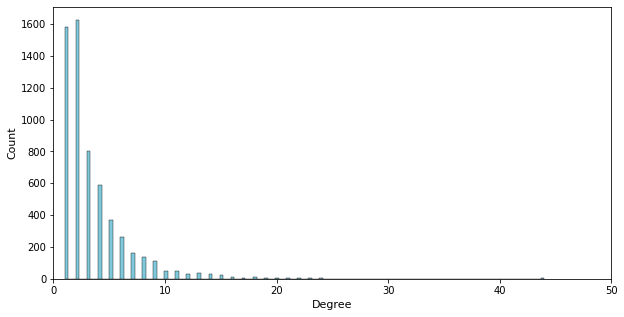

In [ ]:
# Produce histogram of degree distribution to show that distribution obeys power law 
plt.figure(figsize=(10,5))
chart = sns.histplot(data = results, 
                     x = "degree", 
                     color = "#55b8d1")
plt.xlim([0, 50])
chart.set_xlabel("Degree", fontsize = 11)
chart.set_ylabel("Count", fontsize = 11)

# **4. Create a Cypher Projection**

In [ ]:
# Drop in-memory graph if one of the same name already exists 

graph_name = "undirected_graph"

query_string = '''
CALL gds.graph.drop("undirected_graph", false) YIELD graphName
'''

conn.query(query_string)

[]

In [ ]:
# Create an in-memory graph 

query_string = '''
CALL gds.graph.project.cypher(
     "undirected_graph",
    'MATCH (p:Person) RETURN id(p) AS id',
    'MATCH (s:Person)-[r]-(t:Person) RETURN id(s) AS source, id(t) AS target'
)
'''
conn.query(query_string)

[<Record nodeQuery='MATCH (p:Person) RETURN id(p) AS id' relationshipQuery='MATCH (s:Person)-[r]-(t:Person) RETURN id(s) AS source, id(t) AS target' graphName='undirected_graph' nodeCount=5927 relationshipCount=20007 projectMillis=8211>]

# **5. Run Weakly Connected Components Algorithm on the Whole Graph**

In [ ]:
# Run WCC algorithm and write out the component id as a property back to the graph 
# Provides the stats as well so no need to call "stats" separately 
query_string = '''
CALL gds.wcc.write(
    "undirected_graph",
    {
        writeProperty: "componentId"
    }
)
'''

conn.query(query_string)

[<Record writeMillis=714 nodePropertiesWritten=5927 componentCount=1057 componentDistribution={'p99': 12, 'min': 1, 'max': 2854, 'mean': 5.607379375591296, 'p90': 5, 'p50': 2, 'p999': 32, 'p95': 6, 'p75': 3} postProcessingMillis=103 preProcessingMillis=0 computeMillis=189 configuration={'jobId': '37a6b315-9ff6-4018-bfc7-1f6a92c7fa4a', 'writeConcurrency': 4, 'seedProperty': None, 'consecutiveIds': False, 'writeProperty': 'componentId', 'threshold': 0.0, 'nodeLabels': ['*'], 'sudo': False, 'relationshipTypes': ['*'], 'concurrency': 4}>]

In [ ]:
# Return a list of components in descending order of size
query_string = '''
MATCH (p:Person)
RETURN p.componentId, COUNT(*) AS num
ORDER BY num DESC
LIMIT 100
'''

conn.query(query_string)

results = pd.DataFrame([dict(_) for _ in conn.query(query_string)])

results.head()

,p.componentId,num
0,0,2854
1,23,32
2,1981,22
3,1589,21
4,4450,20


# **6. Run Node Degree Calculation and PageRank Algorithm on the Whole Graph**

In [ ]:
# Run the node degree calculation for the whole graph 

query_string = '''
CALL gds.degree.stream("undirected_graph")
YIELD nodeId, score
RETURN gds.util.asNode(nodeId).full_name AS name, gds.util.asNode(nodeId).id AS id, score
ORDER BY score DESC
'''

conn.query(query_string)

results = pd.DataFrame([dict(_) for _ in conn.query(query_string)])

results.head(10)


,name,id,score
0,C STEDMAN (id: 749),749,44.0
1,W HARRIS (id: 4600),4600,44.0
2,J RAMSDEN (id: 430),430,42.0
3,R BATE (id: 566),566,41.0
4,R RUST (id: 728),728,24.0
5,W SIMMS (id: 2266),2266,24.0
6,W FRODSHAM (id: 786),786,23.0
7,G ADAMS (id: 551),551,23.0
8,B COLE (id: 166),166,23.0
9,J GILBERT (id: 182),182,23.0


In [ ]:
# Run PageRank and return a list of the top 10 highest-ranking individuals 
query_string = '''
CALL gds.pageRank.stream("undirected_graph")
YIELD nodeId, score
RETURN gds.util.asNode(nodeId).full_name AS name, gds.util.asNode(nodeId).id AS id, score
ORDER BY score DESC
'''

conn.query(query_string)

results = pd.DataFrame([dict(_) for _ in conn.query(query_string)])

results.head(10)

,name,id,score
0,C STEDMAN (id: 749),749,9.632988
1,W HARRIS (id: 4600),4600,8.885842
2,R BATE (id: 566),566,7.631801
3,J RAMSDEN (id: 430),430,6.932740
4,J WHITE (id: 3777),3777,4.756438
5,W NICHOLL (id: 3453),3453,4.712187
6,R RUST (id: 728),728,4.486798
7,W COOK (id: 1094),1094,4.354304
8,A WELLINGTON (id: 325),325,4.312250
9,L CASELLA (id: 4254),4254,4.063447


# **7. Run Louvain Algorithm**

In [ ]:
# Run the Louvain algorithm
query_string = '''
CALL gds.louvain.write("undirected_graph", {writeProperty: "louv"}) 
YIELD communityCount, modularity, modularities
'''

conn.query(query_string)

[<Record communityCount=1097 modularity=0.9583052689193612 modularities=[0.7990324793829534, 0.933295348927071, 0.9564826050073759, 0.9583052689193612]>]

# **8. Distribution of Communities by Size**

In [ ]:
# Calculate the total number of communities generated by Louvain 
total = len(results["community_size"])
print(total)

1097


In [ ]:
# Generate a table of Louvain communities, arranged in descending order of size
# Top 10 largest communities shown here 

query_string = '''
MATCH (p:Person)
RETURN p.louv as community,
count(DISTINCT p) as community_size
ORDER BY community_size DESC
'''

conn.query(query_string)

results = pd.DataFrame([dict(_) for _ in conn.query(query_string)])

results.head(10)

,community,community_size
0,2609,137
1,2535,131
2,619,128
3,202,116
4,1491,114
5,3009,109
6,2349,102
7,372,101
8,974,100
9,4409,98


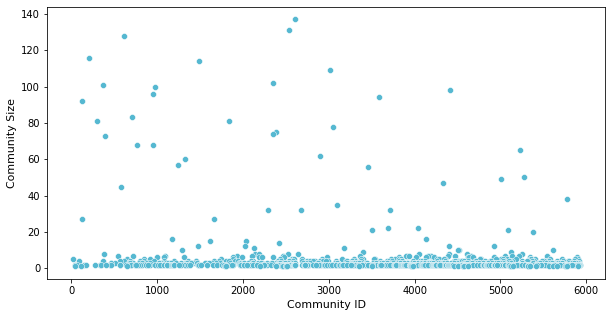

In [ ]:
# Distribution of community size  
plt.figure(figsize=(10,5))
chart = sns.scatterplot(data = results, 
                      x = "community",
                      y = "community_size",
                      color = "#55b8d1")
#chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
chart.set_xlabel("Community ID", fontsize = 11)
chart.set_ylabel("Community Size", fontsize = 11)
plt.savefig("comm_size_scatter.svg")

In [ ]:
# Calulate proportion of communities with 5 or fewer members
# Use this with the scatter plot to illustrate the large proportion of small communities 
under_5 = sum(results["community_size"] <= 5)
total = len(results["community_size"])
prop_under_5 = under_5/total
print(prop_under_5)
print(under_5)

0.9006381039197813
988


In [ ]:
# Calulate proportion of communities with 10 or fewer members
# Use this with the scatter plot to illustrate the large proportion of small communities 
under_10 = sum(results["community_size"] <= 10)
total = len(results["community_size"])
prop_under_10 = under_10/total
print(prop_under_10)
print(under_10)

0.95077484047402
1043


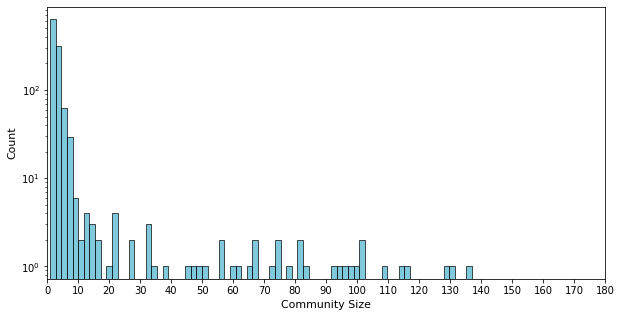

In [ ]:
# Produce histogram of community size on log scale
plt.figure(figsize=(10,5))
chart = sns.histplot(data = results, 
                     x = "community_size", 
                     bins = 75, 
                     color = "#55b8d1",
                     log_scale = (False, True))
chart.set_xlabel("Community Size", fontsize = 11)
chart.set_ylabel("Count", fontsize = 11)
chart.xaxis.set_major_locator(ticker.MultipleLocator(10))
chart.xaxis.set_major_formatter(ticker.ScalarFormatter())
chart.set_xlim([0,180])
plt.savefig("comm_size_hist.svg")

# **9. Community Profiles**

In [ ]:
# Louvain community profile by years of activity

query_string = '''
MATCH (p:Person)-[:WAS_ACTIVE_IN]->(l:Location) with p, p.year_from as year_from, p.year_to as year_to
RETURN p.louv as community,
       count(DISTINCT p) as community_size,
       min(year_from) as earliest_commencement_date,
       max(year_from) as latest_commencement_date,
       max(year_to) as latest_cessation_date 
ORDER BY community_size DESC
'''

conn.query(query_string)

results = pd.DataFrame([dict(_) for _ in conn.query(query_string)])

results["span_years"] = results["latest_cessation_date"] - results["earliest_commencement_date"]

results_20 = results.head(20).sort_values(by = ["span_years"], ascending=False)

results_20

,community,community_size,earliest_commencement_date,latest_commencement_date,latest_cessation_date,span_years
17,2382,75,1667,1930,2004,337
15,710,79,1576,1850,1900,324
12,3590,91,1637,1907,1946,309
0,2609,137,1633,1872,1940,307
2,619,127,1667,1913,1960,293
9,974,97,1620,1873,1907,287
3,202,112,1647,1860,1915,268
1,2535,131,1729,1932,1991,262
16,3053,77,1710,1960,1960,250
14,302,80,1738,1910,1988,250


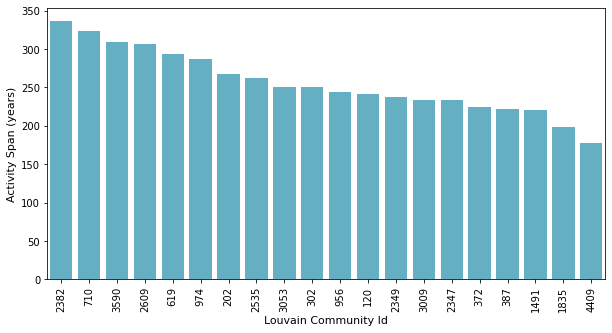

In [ ]:
# Distribution of time span of activity in years by Louvain community for the 20 communities with the longest duration   
plt.figure(figsize=(10,5))
chart = sns.barplot(data = results_20, 
                      x = "community",
                      y = "span_years",
                      order = results_20.sort_values("span_years", ascending = False).community,
                      color = "#55b8d1")
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
chart.set_xlabel("Louvain Community Id", fontsize = 11)
chart.set_ylabel("Activity Span (years)", fontsize = 11)
plt.savefig("comm_duration.svg")

In [ ]:
# Top 10 Louvain community profiles by number of makers
# Number of high and low level locations, guild memberships and numbers of products made and sold is summarised for each community

query_string = '''
MATCH (p:Person)
OPTIONAL MATCH (p:Person)-[:HAD_GEO_LOCATION]->(st:Street)
OPTIONAL MATCH (p:Person)-[:WAS_ACTIVE_IN]->(l:Location)
OPTIONAL MATCH (p:Person)-[:MEMBER_OF]->(g:Guild)
OPTIONAL MATCH (p:Person)-[r:PRIMARY_ROLE]->(primary)
OPTIONAL MATCH (p:Person)-[o:OTHER_TRADE]->(other)
OPTIONAL MATCH (p:Person)-[m:MADE]->(maker) 
OPTIONAL MATCH (p:Person)-[s:SOLD]->(seller) 
RETURN p.louv as community,
       count(DISTINCT p) as community_size,
       count(DISTINCT st.coord_string) as number_of_streets,
       count(DISTINCT l.location) as number_of_towns,
       count(DISTINCT g.name) as number_of_guilds,
       count(DISTINCT primary.description) as number_of_primary_roles,
       count(DISTINCT other.description) as number_of_other_trades,
       count(DISTINCT maker.product) as number_of_products_made,
       count(DISTINCT seller.product) as number_of_products_sold
ORDER BY community_size DESC
'''

conn.query(query_string)

results = pd.DataFrame([dict(_) for _ in conn.query(query_string)])

results.head(10)


,community,community_size,number_of_streets,number_of_towns,number_of_guilds,number_of_primary_roles,number_of_other_trades,number_of_products_made,number_of_products_sold
0,2609,137,46,10,12,7,4,21,0
1,2535,131,33,28,2,13,7,25,2
2,619,128,58,22,9,8,5,20,2
3,202,116,39,21,12,13,10,11,4
4,1491,114,53,31,5,10,1,24,6
5,3009,109,56,15,7,11,2,12,2
6,2349,102,44,12,5,1,3,9,0
7,372,101,35,23,7,5,2,11,0
8,974,100,64,17,6,4,3,7,2
9,4409,98,42,15,5,2,2,14,0


#**10. Queries to Address Communities of Place Question - High Level**


In [ ]:
# Queries using high level locations

In [ ]:
# Largest community
# Copy and paste into Neo4j browser or into GraphXR query tab 
'''
MATCH (p:Person)-[:WAS_ACTIVE_IN]->(l:Location) with p.louv as community, collect(l) as locations, collect(p) as members 
WHERE community = 2609
UNWIND members as member
RETURN member,locations
'''

In [ ]:
# Second largest community
'''
MATCH (p:Person)-[:WAS_ACTIVE_IN]->(l:Location) with p.louv as community, collect(l) as locations, collect(p) as members 
WHERE community = 2535
UNWIND members as member
RETURN member,locations
'''

In [ ]:
# Third largest community
'''
MATCH (p:Person)-[:WAS_ACTIVE_IN]->(l:Location) with p.louv as community, collect(l) as locations, collect(p) as members 
WHERE community = 619
UNWIND members as member
RETURN member,locations
'''

In [ ]:
# Fourth largest community
'''
MATCH (p:Person)-[:WAS_ACTIVE_IN]->(l:Location) with p.louv as community, collect(l) as locations, collect(p) as members 
WHERE community = 202
UNWIND members as member
RETURN member,locations
'''

In [ ]:
# Fifth largest community 
'''
MATCH (p:Person)-[:WAS_ACTIVE_IN]->(l:Location) with p.louv as community, collect(l) as locations, collect(p) as members 
WHERE community = 1491
UNWIND members as member
RETURN member,locations
'''

#**11. Queries to Address Communities of Place Question - Low Level**

In [ ]:
# Largest community
'''
MATCH (p:Person)-[:HAD_ADDRESS]->(a:Address)
MATCH (a)-[:HAD_GEOLOCATION]->(geo)
with p.louv as community, collect(a) as addresses, collect(geo) as geolocations, collect(p) as members
WHERE community = 2609
UNWIND members as member
RETURN member, addresses, geolocations
'''

In [ ]:
# Second largst community
'''
MATCH (p:Person)-[:HAD_ADDRESS]->(a:Address)
MATCH (a)-[:HAD_GEOLOCATION]->(geo)
with p.louv as community, collect(a) as addresses, collect(geo) as geolocations, collect(p) as members
WHERE community = 2535
UNWIND members as member
RETURN member, addresses, geolocations
'''

In [ ]:
# Second largest community just the addresses
'''
MATCH (p:Person)-[:HAD_ADDRESS]->(a:Address)
MATCH (a)-[:HAD_GEOLOCATION]->(geo)
with p.louv as community, collect(a) as addresses, collect(geo) as geolocations, collect(p) as members
WHERE community = 2535
UNWIND members as member
RETURN addresses, geolocations
'''

In [ ]:
# Third largest community
'''
MATCH (p:Person)-[:HAD_ADDRESS]->(a:Address)
MATCH (a)-[:HAD_GEOLOCATION]->(geo)
with p.louv as community, collect(a) as addresses, collect(geo) as geolocations, collect(p) as members
WHERE community = 619
UNWIND members as member
RETURN member, addresses, geolocations
'''

In [ ]:
# Fourth largest community
'''
MATCH (p:Person)-[:HAD_ADDRESS]->(a:Address)
MATCH (a)-[:HAD_GEOLOCATION]->(geo)
with p.louv as community, collect(a) as addresses, collect(geo) as geolocations, collect(p) as members
WHERE community = 202
UNWIND members as member
RETURN member, addresses, geolocations
'''

In [ ]:
# Fifth largest community
'''
MATCH (p:Person)-[:HAD_ADDRESS]->(a:Address)
MATCH (a)-[:HAD_GEOLOCATION]->(geo)
with p.louv as community, collect(a) as addresses, collect(geo) as geolocations, collect(p) as members
WHERE community = 1491
UNWIND members as member
RETURN member, addresses, geolocations
'''

In [ ]:
# Fifth largest community just the addresses 
'''
MATCH (p:Person)-[:HAD_ADDRESS]->(a:Address)
MATCH (a)-[:HAD_GEOLOCATION]->(geo)
with p.louv as community, collect(a) as addresses, collect(geo) as geolocations, collect(p) as members
WHERE community = 1491
UNWIND members as member
RETURN addresses, geolocations
'''

In [ ]:
# Fifth largest community - how to get all addresses and makers for coordinate label of interest
'''
MATCH (p:Person)-[:HAD_ADDRESS]->(a:Address)
MATCH (a)-[:HAD_GEOLOCATION]->(geo)
with p.louv as community, geo.coord_string as coord, collect(a) as addresses, collect(geo) as geolocations, collect(p) as members
WHERE community = 1491 AND coord = "51.5207627358765-0.10985255241394"
UNWIND members as member
RETURN member, community, addresses, geolocations
'''

#**12. Queries to Address Communities of Affiliation Question**

In [ ]:
# Largest community
''' 
MATCH (p:Person)
OPTIONAL MATCH (p:Person)-[:MEMBER_OF]->(g:Guild) 
with p.louv as community, collect(g) as guilds, collect(p) as members 
WHERE community = 2609
CALL apoc.create.vNodes(['Community'], [{name:community}]) YIELD node as comm 
UNWIND members as member
RETURN member, guilds
'''

In [ ]:
# Second largest community
# This only has 2 guilds
''' 
MATCH (p:Person)
OPTIONAL MATCH (p:Person)-[:MEMBER_OF]->(g:Guild) 
with p.louv as community, collect(g) as guilds, collect(p) as members 
WHERE community = 2535
CALL apoc.create.vNodes(['Community'], [{name:community}]) YIELD node as comm 
UNWIND members as member
RETURN member, guilds
'''

In [ ]:
# Third largest community
''' 
MATCH (p:Person)
OPTIONAL MATCH (p:Person)-[:MEMBER_OF]->(g:Guild) 
with p.louv as community, collect(g) as guilds, collect(p) as members 
WHERE community = 619
CALL apoc.create.vNodes(['Community'], [{name:community}]) YIELD node as comm 
UNWIND members as member
RETURN member, guilds
'''

In [ ]:
# Fourth largest community
''' 
MATCH (p:Person)
OPTIONAL MATCH (p:Person)-[:MEMBER_OF]->(g:Guild) 
with p.louv as community, collect(g) as guilds, collect(p) as members 
WHERE community = 202
CALL apoc.create.vNodes(['Community'], [{name:community}]) YIELD node as comm 
UNWIND members as member
RETURN member, guilds
'''

In [ ]:
# Fifth largest community 
''' 
MATCH (p:Person)
OPTIONAL MATCH (p:Person)-[:MEMBER_OF]->(g:Guild) 
with p.louv as community, collect(g) as guilds, collect(p) as members 
WHERE community = 1491
CALL apoc.create.vNodes(['Community'], [{name:community}]) YIELD node as comm 
UNWIND members as member
RETURN member, guilds
'''

In [ ]:
# Ask an additional question with second largest community: was guild memebership associated with being in particular geographic location?
''' 
MATCH (p:Person)-[:MEMBER_OF]->(g:Guild) 
OPTIONAL MATCH (p:Person)-[:WAS_ACTIVE_IN]->(l:Location)
with p.louv as community, collect(g) as guilds, collect(l) as locations, collect(p) as members 
WHERE community = 2535
CALL apoc.create.vNodes(['Community'], [{name:community}]) YIELD node as comm 
UNWIND members as member
RETURN member, guilds, locations
'''

#**13. Queries to Address Communities of Product Question**


In [ ]:
# Largest community
''' 
MATCH (p:Person) 
OPTIONAL MATCH (p:Person)-[:MADE]->(m:Maker_Of)
OPTIONAL MATCH (p:Person)-[:SOLD]->(s:Seller_Of)
with p.louv as community, collect(m) as products_made, collect(s) as products_sold, collect(p) as members 
WHERE community = 2609 
UNWIND members as member
RETURN member, products_made, products_sold
'''

In [ ]:
# Second largest community
''' 
MATCH (p:Person) 
OPTIONAL MATCH (p:Person)-[:MADE]->(m:Maker_Of)
OPTIONAL MATCH (p:Person)-[:SOLD]->(s:Seller_Of)
with p.louv as community, collect(m) as products_made, collect(s) as products_sold, collect(p) as members 
WHERE community = 2535 
UNWIND members as member
RETURN member, products_made, products_sold
'''

In [ ]:
# Third largest community
''' 
MATCH (p:Person) 
OPTIONAL MATCH (p:Person)-[:MADE]->(m:Maker_Of)
OPTIONAL MATCH (p:Person)-[:SOLD]->(s:Seller_Of)
with p.louv as community, collect(m) as products_made, collect(s) as products_sold, collect(p) as members 
WHERE community = 619 
UNWIND members as member
RETURN member, products_made, products_sold
'''

In [ ]:
# Fourth largest community
''' 
MATCH (p:Person) 
OPTIONAL MATCH (p:Person)-[:MADE]->(m:Maker_Of)
OPTIONAL MATCH (p:Person)-[:SOLD]->(s:Seller_Of)
with p.louv as community, collect(m) as products_made, collect(s) as products_sold, collect(p) as members 
WHERE community = 202 
UNWIND members as member
RETURN member, products_made, products_sold
'''

In [ ]:
# Fifth largest community 
''' 
MATCH (p:Person) 
OPTIONAL MATCH (p:Person)-[:MADE]->(m:Maker_Of)
OPTIONAL MATCH (p:Person)-[:SOLD]->(s:Seller_Of)
with p.louv as community, collect(m) as products_made, collect(s) as products_sold, collect(p) as members 
WHERE community = 1491 
UNWIND members as member
RETURN member, products_made, products_sold
'''


#**13. Queries to Address Communities Over Time Question**

In [ ]:
# Largest community
'''
MATCH (p:Person)-[:OPERATED_DURING]->(t:Time) 
with p.louv as community, collect(t) as times, collect(p) as members 
WHERE community = 2609
CALL apoc.create.vNodes(['Community'], [{name:community}]) YIELD node as comm 
UNWIND members as member
RETURN member, times
'''

In [ ]:
# Second largest community
'''
MATCH (p:Person)
MATCH (t:Time)
with p.louv as community,collect(p) as members
UNWIND t.start as start
UNWIND t.end as end
RETURN start, end
'''

In [ ]:
# Third largest community

In [ ]:
# Fourth largest community

In [ ]:
# Fifth largest community 

# **9. Tabulated Queries Relating to Stedman FOR DELETION**

In [ ]:
# Find Stedman's community (individual with the highest node degree and PageRank score) using his ID as generated above 

query_string = '''
MATCH (p:Person)
WHERE p.id = 749
RETURN p.louv as community
'''

conn.query(query_string)

[<Record community=1240>]

In [ ]:
# Summarise Stedman's community as a table 

query_string = '''
MATCH (p:Person)
OPTIONAL MATCH (p:Person)-[:WAS_ACTIVE_IN]->(l:Location)
OPTIONAL MATCH (p:Person)-[:MEMBER_OF]->(g:Guild)
OPTIONAL MATCH (p:Person)-[r:PRIMARY_ROLE]->(primary)
OPTIONAL MATCH (p:Person)-[o:OTHER_TRADE]->(other)
OPTIONAL MATCH (p:Person)-[m:MADE]->(maker) 
OPTIONAL MATCH (p:Person)-[s:SOLD]->(seller) 
RETURN p.louv as community,
       count(DISTINCT p) as community_size,
       count(DISTINCT l.location) as number_of_locations,
       count(DISTINCT g.name) as number_of_guilds,
       count(DISTINCT primary.description) as number_of_primary_roles,
       count(DISTINCT other.description) as number_of_other_trades,
       count(DISTINCT maker.product) as number_of_products_made,
       count(DISTINCT seller.product) as number_of_products_sold
ORDER BY community_size DESC
'''

conn.query(query_string)

results = pd.DataFrame([dict(_) for _ in conn.query(query_string)])

stedman_comm = results[results["community"] == 5198]

stedman_comm


,community,community_size,number_of_locations,number_of_guilds,number_of_primary_roles,number_of_other_trades,number_of_products_made,number_of_products_sold


In [ ]:
# Visualisation: copy code between ''' to Neo4j browser
'''
MATCH (p:Person)-[:WAS_ACTIVE_IN]->(l:Location) 
OPTIONAL MATCH (p:Person)-[:MEMBER_OF]->(g:Guild) 
OPTIONAL MATCH (p:Person)-[:MADE]->(m:Maker_Of)
with p.louv as community, collect(l) as locations, collect(g) as guilds, collect(m) as products_made, collect(p) as members 
WHERE community = 5198
CALL apoc.create.vNodes(['Community'], [{name:community}]) YIELD node as comm 
UNWIND members as member
CALL apoc.create.vRelationship(member,'MEMBER_OF_COMMUNITY',{}, comm) YIELD rel 
RETURN member,rel, locations, guilds, products_made
'''

# **9. Community Evolution FOR DELETION**

In [ ]:
# Generate a table of Louvain communities, arranged in descending order of size
# Top 10 largest communities shown here 

query_string = '''
MATCH (p:Person)
RETURN p.louv as community,
count(DISTINCT p) as community_size
ORDER BY community_size DESC
'''

conn.query(query_string)

results = pd.DataFrame([dict(_) for _ in conn.query(query_string)])

#results["log_community_size"] = 

results.head(50)

,community,community_size
0,2637,180
1,2535,129
2,1491,125
3,974,112
4,202,109
5,3009,109
6,372,101
7,4409,98
8,1867,97
9,956,96


In [ ]:
query_string = '''
MATCH (p:Person)
WHERE p.id = 923
RETURN p.louv as community
'''
conn.query(query_string)

[<Record community=2031>]

In [ ]:
# Return a particular community for time span query 

# Louvain community profile by years of activity

query_string = '''
MATCH (p:Person)-[:WAS_ACTIVE_IN]->(l:Location) with p, p.year_from as year_from, p.year_to as year_to
WHERE p.louv = 4567
RETURN p.louv as community,
       count(DISTINCT p) as community_size,
       min(year_from) as earliest_commencement_date,
       max(year_from) as latest_commencement_date,
       max(year_to) as latest_cessation_date 
ORDER BY community_size DESC
'''

conn.query(query_string)

results = pd.DataFrame([dict(_) for _ in conn.query(query_string)])

results["span_years"] = results["latest_cessation_date"] - results["earliest_commencement_date"] 

results

,community,community_size,earliest_commencement_date,latest_commencement_date,latest_cessation_date,span_years
0,4567,12,1740,1822,1834,94


In [ ]:
'''
MATCH (p:Person)-[:WAS_ACTIVE_IN]->(l:Location) 
OPTIONAL MATCH (p:Person)-[:MEMBER_OF]->(g:Guild) 
OPTIONAL MATCH (p:Person)-[:MADE]->(m:Maker_Of) with p.louv as community, p.year_from as year_from, collect(l) as locations, collect(g) as guilds, collect(m) as products_made, collect(p) as members 
WHERE community = 4567 AND year_from >=1740 AND year_from <1750  
UNWIND members as member
RETURN member,locations, guilds, products_made
'''

# **9. Queries for Neo4j Browser Visualisation FOR DELETION**

In [ ]:
# The queries in this section that are not prefaced with "query_string" must be copied and pasted into the Neo4j Browser window in order for the corresponsing visualisations to be generated 
# To generate the visualiation, copy and paste the text within the starting and ending ''' marks, excluding the ''' marks themselves 

In [ ]:
# Visualising communities by specific ID
# This query is used to produce the visualisations for the largest 5 communities included in the dissertation Results section 

'''
MATCH (p:Person)-[:WAS_ACTIVE_IN]->(l:Location) 
OPTIONAL MATCH (p:Person)-[:MEMBER_OF]->(g:Guild) 
OPTIONAL MATCH (p:Person)-[:MADE]->(m:Maker_Of)
with p.louv as community, collect(l) as locations, collect(g) as guilds, collect(m) as products_made, collect(p) as members 
WHERE community = 943
CALL apoc.create.vNodes(['Community'], [{name:community}]) YIELD node as comm 
UNWIND members as member
CALL apoc.create.vRelationship(member,'MEMBER_OF_COMMUNITY',{}, comm) YIELD rel 
RETURN member,rel, locations, guilds, products_made
'''

In [ ]:
# Find the community of a person of interest 

query_string = '''
MATCH (p:Person)
WHERE p.id = 749
RETURN p.louv as community
'''

conn.query(query_string)

[<Record community=1240>]

In [ ]:
# Simple query to visualise a specific community by its members

'''
MATCH (p:Person) with p, p.louv as community
WHERE community = 842
RETURN p
'''

In [ ]:
# Extending the above to include associated locations
# This query does not return the community number as a separate node to avoid overcrowding the resulting visualisation
# A community number node can be added by including the string 'comm' in the RETURN statement 

'''
MATCH (p:Person)-[:WAS_ACTIVE_IN]->(l:Location) with p.louv as community, collect(l) as locations, collect(p) as members 
WHERE community = 842
CALL apoc.create.vNodes(['Community'], [{name:community}]) YIELD node as comm 
UNWIND members as member
CALL apoc.create.vRelationship(member,'MEMBER_OF_COMMUNITY',{}, comm) YIELD rel 
RETURN member,rel,locations
'''

In [ ]:
# Further extending the above to bring in guild memberships

'''
MATCH (p:Person)-[:WAS_ACTIVE_IN]->(l:Location) 
OPTIONAL MATCH (g:Guild)<-[:MEMBER_OF]-(p:Person) 
with p.louv as community, collect(l) as locations, collect(g) as guilds, collect(p) as members 
WHERE community = 1323
CALL apoc.create.vNodes(['Community'], [{name:community}]) YIELD node as comm 
UNWIND members as member
CALL apoc.create.vRelationship(member,'MEMBER_OF_COMMUNITY',{}, comm) YIELD rel 
RETURN member,rel, locations, guilds
'''

In [ ]:
# Further extending to add in products made 

'''
MATCH (p:Person)-[:WAS_ACTIVE_IN]->(l:Location) 
OPTIONAL MATCH (p:Person)-[:MEMBER_OF]->(g:Guild) 
OPTIONAL MATCH (p:Person)-[:MADE]->(m:Maker_Of)
with p.louv as community, collect(l) as locations, collect(g) as guilds, collect(m) as products_made, collect(p) as members 
WHERE community = 842
CALL apoc.create.vNodes(['Community'], [{name:community}]) YIELD node as comm 
UNWIND members as member
CALL apoc.create.vRelationship(member,'MEMBER_OF_COMMUNITY',{}, comm) YIELD rel 
RETURN member,rel, locations, guilds, products_made
'''

In [ ]:
# Query to find which communities made a particular product 

'''
MATCH (p:Person)-[:MADE]->(m:Maker_Of) with m, p.louv as community,collect(p) as members, collect(m) as products_made
WHERE m.product = "Compass"
CALL apoc.create.vNodes(['Community'], [{name:community}]) YIELD node as comm 
UNWIND members as member 
CALL apoc.create.vRelationship(member,'MEMBER_OF_COMMUNITY',{}, comm) YIELD rel 
RETURN member,rel,comm, products_made
'''

In [ ]:
# CAN DELETE 
'''
MATCH (p:Person)-[:MADE]->(m:Maker_Of) 
OPTIONAL MATCH (p:Person)-[:WAS_ACTIVE_IN]->(l:Location) with m, p.louv as community,collect(p) as members, collect(m) as products_made, collect(l) as locations
WHERE m.product = "Compass"
CALL apoc.create.vNodes(['Community'], [{name:community}]) YIELD node as comm 
UNWIND locations as location
UNWIND products_made as product
CALL apoc.create.vRelationship(comm,'ASSOCIATED_WITH',{}, location) YIELD rel 
CALL apoc.create.vRelationship(product,'MADE_BY',{}, comm) YIELD rel 
RETURN rel,rel,comm, product
'''

In [ ]:
# Extending the above to find which communities made a particular product and the locations with which these communities were associated 

'''
MATCH (p:Person)-[:MADE]->(m:Maker_Of)
OPTIONAL MATCH (p:Person)-[:WAS_ACTIVE_IN]->(l:Location) with m, p.louv as community,collect(p) as members, collect(m) as products_made, collect(l) as locations
WHERE m.product = "Spectacle"
CALL apoc.create.vNodes(['Community'], [{name:community}]) YIELD node as comm 
UNWIND members as member 
CALL apoc.create.vRelationship(member,'MEMBER_OF_COMMUNITY',{}, comm) YIELD rel 
RETURN member,rel,comm, products_made, locations
'''

In [ ]:
# Extending the above query to include guild memberships

'''
MATCH (p:Person)-[:MADE]->(m:Maker_Of)
OPTIONAL MATCH (p:Person)-[:WAS_ACTIVE_IN]->(l:Location) 
OPTIONAL MATCH (p:Person)-[:MEMBER_OF]->(g:Guild) with m, p.louv as community,collect(p) as members, collect(m) as products_made, collect(l) as locations, collect(g) as guilds
WHERE m.product = "Spectacle"
CALL apoc.create.vNodes(['Community'], [{name:community}]) YIELD node as comm 
UNWIND members as member 
CALL apoc.create.vRelationship(member,'MEMBER_OF_COMMUNITY',{}, comm) YIELD rel 
RETURN member,rel,comm, products_made, locations, guilds
'''

In [ ]:
# Query looking at which members of which communities both made and sold items 
# This query is for all products 

'''
MATCH (s:Seller_Of)<-[:SOLD]-(p:Person)-[:MADE]->(m:Maker_Of) with m,s, p.louv as community,collect(p) as members, collect(m) as products_made, collect(s) as products_sold
WHERE m.product = "Umbrella"
CALL apoc.create.vNodes(['Community'], [{name:community}]) YIELD node as comm 
UNWIND members as member 
CALL apoc.create.vRelationship(member,'MEMBER_OF_COMMUNITY',{}, comm) YIELD rel 
RETURN member,rel,comm, products_made, products_sold
'''

In [ ]:
# Extending the above query to include location and guild membership information as well

'''
MATCH (s:Seller_Of)<-[:SOLD]-(p:Person)-[:MADE]->(m:Maker_Of)
OPTIONAL MATCH (p:Person)-[:WAS_ACTIVE_IN]->(l:Location) 
OPTIONAL MATCH (p:Person)-[:MEMBER_OF]->(g:Guild) with m,s, p.louv as community,collect(p) as members, collect(m) as products_made, collect(s) as products_sold, collect(l) as locations, collect(g) as guilds
CALL apoc.create.vNodes(['Community'], [{name:community}]) YIELD node as comm 
UNWIND members as member 
CALL apoc.create.vRelationship(member,'MEMBER_OF_COMMUNITY',{}, comm) YIELD rel 
RETURN member,rel,comm, products_made, products_sold, locations, guilds
'''

In [ ]:
# Members and associated communities where members both made a specific product and sold an item 
# Query includes location and guild information so can be trimmed if required 

'''
MATCH (s:Seller_Of)<-[:SOLD]-(p:Person)-[:MADE]->(m:Maker_Of)
OPTIONAL MATCH (p:Person)-[:WAS_ACTIVE_IN]->(l:Location) 
OPTIONAL MATCH (p:Person)-[:MEMBER_OF]->(g:Guild) with m,s, p.louv as community,collect(p) as members, collect(m) as products_made, collect(s) as products_sold, collect(l) as locations, collect(g) as guilds
WHERE m.product = "Salinometer"
CALL apoc.create.vNodes(['Community'], [{name:community}]) YIELD node as comm 
UNWIND members as member 
CALL apoc.create.vRelationship(member,'MEMBER_OF_COMMUNITY',{}, comm) YIELD rel 
RETURN member,rel,comm, products_made, products_sold, locations, guilds
'''

In [ ]:
# All communities in a particular location 

In [ ]:
# Query to generate the evolution of a community over time with the desired parameters 
# This query returns information on location, guild and products made as well as showing the constituent members of a certain community over a specified period

'''
MATCH (p:Person)-[:WAS_ACTIVE_IN]->(l:Location) 
OPTIONAL MATCH (p:Person)-[:MEMBER_OF]->(g:Guild) 
OPTIONAL MATCH (p:Person)-[:MADE]->(m:Maker_Of) with p.louv as community, p.year_from as year_from, collect(l) as locations, collect(g) as guilds, collect(m) as products_made, collect(p) as members 
WHERE community = 38 AND year_from >=1700 AND year_from <1800  
UNWIND members as member
RETURN member,locations, guilds, products_made
'''

In [ ]:
'''
MATCH(p:Person)-[:MADE]->(m:Maker_Of) with m, p.louv as community, collect(p) as members, collect(m) as products_made
WHERE m.product = "Umbrella"
CALL apoc.create.vNodes(['Community'], [{name:community}]) YIELD node as comm 
UNWIND members as member 
CALL apoc.create.vRelationship(member,'MEMBER_OF_COMMUNITY',{}, comm) YIELD rel 
RETURN member,rel,comm, products_made
'''

'\nMATCH (s:Seller_Of)<-[:SOLD]-(p:Person)-[:MADE]->(m:Maker_Of) with m,s, p.louv as community,collect(p) as members, collect(m) as products_made, collect(s) as products_sold\nWHERE m.product = "Umbrella"\nCALL apoc.create.vNodes([\'Community\'], [{name:community}]) YIELD node as comm \nUNWIND members as member \nCALL apoc.create.vRelationship(member,\'MEMBER_OF_COMMUNITY\',{}, comm) YIELD rel\nWITH DISTINCT community \nRETURN member,rel,comm, products_made, products_sold\n'

In [ ]:
'''
MATCH (p:Person)-[:WAS_ACTIVE_IN]->(l:Location) 
OPTIONAL MATCH (p:Person)-[:MEMBER_OF]->(g:Guild) 
OPTIONAL MATCH (p:Person)-[:MADE]->(m:Maker_Of)
with p.louv as community, collect(l) as locations, collect(g) as guilds, collect(m) as products_made, collect(p) as members 
WHERE community = 1323
CALL apoc.create.vNodes(['Community'], [{name:community}]) YIELD node as comm 
UNWIND members as member
CALL apoc.create.vRelationship(member,'MEMBER_OF_COMMUNITY',{}, comm) YIELD rel 
RETURN member,rel, locations, guilds, products_made
'''

In [ ]:
# Return a particular community for time span query 

# Louvain community profile by years of activity

query_string = '''
MATCH (p:Person)-[:WAS_ACTIVE_IN]->(l:Location) with p, p.year_from as year_from, p.year_to as year_to
WHERE p.louv = 1038
RETURN p.louv as community,
       count(DISTINCT p) as community_size,
       min(year_from) as earliest_commencement_date,
       max(year_from) as latest_commencement_date,
       max(year_to) as latest_cessation_date 
ORDER BY community_size DESC
'''

conn.query(query_string)

results = pd.DataFrame([dict(_) for _ in conn.query(query_string)])

results["span_years"] = results["latest_cessation_date"] - results["earliest_commencement_date"] 

results


,community,community_size,earliest_commencement_date,latest_commencement_date,latest_cessation_date,span_years
0,1038,21,1763,1882,1882,119


In [ ]:
results

,community,community_size,earliest_commencement_date,latest_commencement_date,latest_cessation_date,span_years
0,1323,57,1714,1901,1913,199


In [ ]:
'''
MATCH (p:Person)-[:WAS_ACTIVE_IN]->(l:Location) 
OPTIONAL MATCH (p:Person)-[:MEMBER_OF]->(g:Guild) 
OPTIONAL MATCH (p:Person)-[:MADE]->(m:Maker_Of) with p.louv as community, p.year_from as year_from, collect(l) as locations, collect(g) as guilds, collect(m) as products_made, collect(p) as members 
WHERE community = 1038 AND year_from >=1760 AND year_from <1780  
UNWIND members as member
RETURN member,locations, guilds, products_made
'''

In [ ]:
'''
MATCH (p:Person)-[]->(p1:Person) 
WHERE p.id = 749
RETURN p, p1
'''

In [ ]:
'''
MATCH (p:Person)-[]->(p1:Person) 
MATCH (p:Person)-[:WAS_ACTIVE_IN]->(l:Location) 
MATCH (p:Person)-[:MEMBER_OF]->(g:Guild) 
WHERE p.id = 749
RETURN p, p1, l, g 
'''

In [ ]:
'''
MATCH (p:Person)-[]->(p1:Person) 
WHERE p.last_name = "WATT"
RETURN p, p1
'''

In [ ]:
'''
MATCH (p:Person)-[]->(p1:Person) 
WHERE p.last_name = "WATT"
RETURN p.louv
'''

In [ ]:
'''
MATCH (s)-[assoc:ASSOCIATED_WITH_ADDRESS]->(a)
WHERE s.latitude = "51.5062516547869"
RETURN s, a
'''

# **QUERIES FOR GRAPHXR**

In [ ]:
# Community evolution through time 
'''
MATCH (p)-[o:OPERATED_DURING]->(t) with p.louv as community, collect(t) as timespans, collect(p) as members 
WHERE community = 1606 
UNWIND members as member
RETURN member,timespans
'''

In [ ]:
'''
MATCH (p:Person)-[:WAS_ACTIVE_IN]->(l:Location) 
OPTIONAL MATCH (p:Person)-[:MEMBER_OF]->(g:Guild) with p.louv as community, collect(l) as locations, collect(g) as guilds, collect(p) as members 
WHERE community = 5359 
UNWIND members as member
RETURN member,locations, guilds
'''

In [ ]:
'''
MATCH (s:Seller_Of)<-[:SOLD]-(p:Person)-[:MADE]->(m:Maker_Of) with m,s, p.louv as community,collect(p) as members, collect(m) as products_made, collect(s) as products_sold
WHERE community = 5359
CALL apoc.create.vNodes(['Community'], [{name:community}]) YIELD node as comm 
UNWIND members as member 
CALL apoc.create.vRelationship(member,'MEMBER_OF_COMMUNITY',{}, comm) YIELD rel 
RETURN member,rel,comm, products_made, products_sold
'''

# **Queries Used in Geometric Layouts**

In [ ]:
'''
MATCH (g:Guild)<-[:MEMBER_OF]-(p:Person) 
with p.louv as community, collect(g) as guilds, collect(p) as members 
WHERE community = 202
CALL apoc.create.vNodes(['Community'], [{name:community}]) YIELD node as comm 
UNWIND members as member
CALL apoc.create.vRelationship(member,'MEMBER_OF_COMMUNITY',{}, comm) YIELD rel 
RETURN member,rel, guilds
'''

In [ ]:
'''
MATCH (p:Person)-[:WAS_ACTIVE_IN]->(l:Location) 
OPTIONAL MATCH (p:Person)-[:MEMBER_OF]->(g:Guild) 
OPTIONAL MATCH (p:Person)-[:MADE]->(m:Maker_Of)
with p.louv as community, collect(l) as locations, collect(g) as guilds, collect(m) as products_made, collect(p) as members 
WHERE community = 2637
CALL apoc.create.vNodes(['Community'], [{name:community}]) YIELD node as comm 
UNWIND members as member
CALL apoc.create.vRelationship(member,'MEMBER_OF_COMMUNITY',{}, comm) YIELD rel 
RETURN member,rel, locations, guilds, products_made
'''